In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
import os

import cv2
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

sns.set(rc={'figure.figsize':(20,10)})

In [2]:
from google.colab import drive
drive.mount('/content/drive')
torch.manual_seed(0)

Mounted at /content/drive


Functions

In [3]:

def load_image(folder_name, file_name):
    path = os.path.join(folder_name, file_name)
    image = Image.open(path)
    return image

def load_gray_image(folder_name, file_name):
    image = load_image(folder_name, file_name)
    gray_image = ImageOps.grayscale(image)
    return gray_image


def create_patches(image, patch_size, transform=None): 
  assert(isinstance(image, torch.Tensor) or isinstance(image, np.ndarray))
  assert(len(image.shape) == len(patch_size) and len(image.shape) >= 2)

  new_shape = [ss//ps for ss, ps in zip(image.shape, patch_size)]
  assert(min(new_shape) >= 1)

  result = []
  if len(patch_size) == 3:
    ch_index = -1
    for i, s in enumerate(new_shape):
      if s == 1: ch_index = i
    assert(ch_index != -1) # for the time being we do not handle more complex cases

    h,w = np.append(patch_size[:ch_index], patch_size[ch_index+1:]).astype("int32")
    hs,ws = np.append(new_shape[:ch_index], new_shape[ch_index+1:]).astype("int32")

    a = [0]*3
    for i in range(hs): 
      for j in range(ws):
          a[ch_index]       = slice(0, int(patch_size[ch_index]))
          a[(ch_index+1)%3] = slice(i*h,(i+1)*h)
          a[(ch_index-1)%3] = slice(j*w,(j+1)*w)
          patch = image[tuple(a)].reshape(patch_size)
          if transform: patch = transform(patch) 
          result.append(patch)
  elif len(patch_size) == 2:
    h, w = patch_size[-2:]
    new_shape = new_shape[-2:]
    for i in range(new_shape[0]): 
      for j in range(new_shape[1]):
          patch = image[i*h:(i+1)*h, j*w:(j+1)*w]
          if transform: patch = transform(patch) 
          result.append(patch.reshape(patch_size))
  else: 
    print(f"can not handle shapes {image.shape}, {patch_size}")
  return result

def combine_patches(reconstructed_patches, original_img_size):
  assert(len(reconstructed_patches) > 1)

  patch_size = reconstructed_patches[0].shape 
  ph, pw = patch_size 

  new_shape = [ss//ps for ss, ps in zip(list(original_img_size), list(patch_size))]
  h, w = new_shape[-2:]
  result = np.zeros(original_img_size)

  for i in range(h): 
    for j in range(w):
      result[i*ph:(i+1)*ph, j*pw:(j+1)*pw] = reconstructed_patches[i*w+j]
  return result


def training_loop(num_epochs ,train_data_loader, model, criterion, optimizer , prev_training_loss):
 # training loop
  minimum_loss = 0.0002
  if prev_training_loss != -1:
    minimum_loss = prev_training_loss/3
  for epoch in range(num_epochs):
      for img in train_data_loader:
          # noisy_image = img
          noisy_image = img + amount*torch.randn(tuple(img.shape)).to(device).type(dtype)
          noisy_image = torch.clamp(noisy_image, min=-1, max=1)
          
          encoded, recon = model(noisy_image)
          loss = criterion(recon, img)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      loss_copy = loss.item()
      if loss_copy < minimum_loss: 
          break

      print(f'Epoch:{epoch+1}, Loss:{loss_copy:.4f}')
  return loss_copy 

  #sensitivity should be in range of 0.1-1
def get_anomalous_patches_indexes(heat_map, sensitivity):
  ns = 1
  for s in heat_map.shape: 
    ns *= s
  linear_combined = heat_map.reshape(ns)
  r = np.argsort(linear_combined)

  max_log = np.log(np.max(linear_combined))
  all_logs = np.log(linear_combined+0.1)
  questions_array = all_logs > (max_log-sensitivity)

  anomalous_patches_indexes = np.nonzero(questions_array)[0]
 
  return anomalous_patches_indexes

def get_image_with_patches(indexes, patch_shape_error, folder_name, file_name):
  img = cv2.imread(folder_name + '/' + file_name) 
  for index in indexes:
    j, i = index % w, index//w
    start_point = (j*patch_shape_error[1], i*patch_shape_error[0])
    end_point   = (start_point[0] + patch_shape_error[0] , start_point[1] + patch_shape_error[1])
    color = (255, 0, 0)
    thickness = 10
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
  return img
  

def deserialize(path): 
  numbers = []
  with open(path, 'rt') as f: 
    data = f.read() 
    numbers_array = data.split(', ')
    for n in numbers_array: 
      number = int(n)
      numbers.append(number)

  return numbers



In [4]:
import pandas as pd
import scipy as sp
import numpy as np

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

  #sensitivity should be in range of 0.1-1
def get_anomalous_patches_indexes_with_mahalanobis(train_num, heat_map, num_of_patches, sensitivity, mahalanobis):
  hm = heat_map.flatten()
  losses = (hm*0.5) + (mahalanobis*0.5)
  if train_num == 1 :
    anomalies = losses >= sensitivity
    anomalous_patches_indexes = np.nonzero(losses)[0]
  elif train_num == 2 :
    anomalous_patches_indexes = np.argsort(losses)[:17876]
    anomalous_patches_indexes = anomalous_patches_indexes[17876-num_of_patches:17876]
  return anomalous_patches_indexes, losses

Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 7, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 7, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 3), # -> N, 64, 1, 1
            nn.Tanh()
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 7, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 7, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Loading the image

In [6]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype  = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor 

#loading the picture and changing it to grayscale

file_name = 'DSC_0092.JPG'  
folder_name = '/content/drive/MyDrive/new_floors'

patch_size_train = 28
patch_shape_train = (patch_size_train, patch_size_train)

double_patch_size_train = patch_size_train*2

double_patch_shape_train = (double_patch_size_train, double_patch_size_train)

grayfloor = load_gray_image(folder_name, file_name)
rgb_image = load_image(folder_name, file_name)

to_tensor = transforms.ToTensor()
to_normalize = transforms.Normalize((0.5), (0.5))

image_as_tensor = to_tensor(rgb_image)

(-0.5, 4607.5, 3071.5, -0.5)

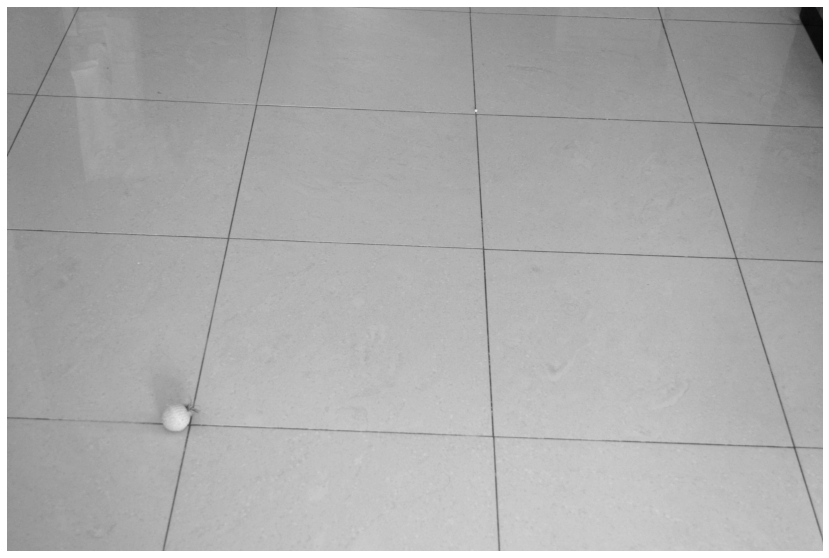

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.imshow(grayfloor, cmap='gray')
plt.axis('off')
# plt.title("Gray scale ")

Creating different size of patches from the image

In [8]:
grayIm_as_tensor = to_tensor(grayfloor)
grayIm_as_tensor = to_normalize(grayIm_as_tensor)
all_data = []
crop_28 = transforms.RandomCrop((28,28))
crop_56 = transforms.RandomCrop((56,56))
crop_112 = transforms.RandomCrop((112,112))

rotation = transforms.RandomRotation(180)
vertical_flip = transforms.RandomVerticalFlip(p=0.5)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
color_jitter = transforms.ColorJitter()

normalized  = torch.stack(create_patches(grayIm_as_tensor, (1, 120, 120)))


croped0 = torch.stack([(crop_28(r)) for r in normalized])
croped1 = torch.stack([color_jitter(crop_28(r)) for r in normalized])
croped2 = torch.stack([vertical_flip(crop_28(r)) for r in normalized])
croped3 = torch.stack([horizontal_flip(crop_28(r)) for r in normalized])
cropped_28 = torch.vstack([croped0, croped1, croped2, croped3])

croped0 = torch.stack([(crop_56(r)) for r in normalized])
croped1 = torch.stack([color_jitter(crop_56(r)) for r in normalized])
croped2 = torch.stack([vertical_flip(crop_56(r)) for r in normalized])
croped3 = torch.stack([horizontal_flip(crop_56(r)) for r in normalized])
cropped_56 = torch.vstack([croped0, croped1, croped2, croped3])

croped0 = torch.stack([(crop_112(r)) for r in normalized])
croped1 = torch.stack([color_jitter(crop_112(r)) for r in normalized])
croped2 = torch.stack([vertical_flip(crop_112(r)) for r in normalized])
croped3 = torch.stack([horizontal_flip(crop_112(r)) for r in normalized])
cropped_112 = torch.vstack([croped0, croped1, croped2, croped3])

all_data.append([cropped_28,cropped_56,cropped_112])
num_of_patches_first_training = (all_data[0][0].shape[0]*3) 
# all_data.append([cropped_56])

In [9]:
print(num_of_patches_first_training)

11400


Initialize the model

In [10]:
losses = []
model = Autoencoder().to(device).type(dtype)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-3, 
                            weight_decay=1e-5)

Training the model (patches from the whole image) and then inserting the image to the model and recieving the reconstructed image:

In [11]:
gf = load_gray_image(folder_name, file_name)
grayfloor_as_tensor = to_normalize(to_tensor(gf))
final_loss = -1

all_latent_vec = []
all_reconstructed_images = []
for k, data in enumerate(all_data):

  for  croped_patch in data :
    # setup data for training
    croped_patch = croped_patch.to(device).type(dtype)

    X_train = croped_patch
    print(len(X_train))
    batch_size = 128 
    train_data_loader = torch.utils.data.DataLoader(dataset=X_train,
                                                    batch_size=batch_size,
                                                    shuffle=True)
    print(k, len(X_train), "epoch:", len(X_train)//batch_size)    
    
    # outputs = []
    amount = 0.02
    num_epochs = len(X_train)//batch_size 
    # training loop
    final_loss= training_loop(num_epochs ,train_data_loader, model, criterion, optimizer , -1)

  # reconstructing the image
  torch.cuda.empty_cache()

  normalized_image = grayfloor_as_tensor.cuda()
  patches_to_reconstruct = create_patches(normalized_image, (1, *patch_shape_train))
  patches = torch.stack(patches_to_reconstruct)

  latent, recon = model(patches)
  reconstructed_images = recon.detach().cpu().numpy()
  latent_vec = latent.detach().cpu().numpy()


  # clear useless cuda memory 
  if recon is not None: del recon; recon = None 
  if latent is not None: del latent; latent = None
  torch.cuda.empty_cache()

  reconstructed_images = reconstructed_images.reshape(len(reconstructed_images), *reconstructed_images.shape[2:])
  reconstructed_images = combine_patches(reconstructed_images, np.array(grayfloor_as_tensor[0]).shape)

  del patches
  torch.cuda.empty_cache()

  all_latent_vec.append(latent_vec)
  

3800
0 3800 epoch: 29
Epoch:1, Loss:0.0027
Epoch:2, Loss:0.0029
Epoch:3, Loss:0.0007
Epoch:4, Loss:0.0009
Epoch:5, Loss:0.0007
Epoch:6, Loss:0.0007
Epoch:7, Loss:0.0011
Epoch:8, Loss:0.0003
Epoch:9, Loss:0.0005
Epoch:10, Loss:0.0006
Epoch:11, Loss:0.0005
Epoch:12, Loss:0.0004
Epoch:13, Loss:0.0005
Epoch:14, Loss:0.0004
Epoch:15, Loss:0.0004
Epoch:16, Loss:0.0006
Epoch:17, Loss:0.0004
Epoch:18, Loss:0.0005
Epoch:19, Loss:0.0004
Epoch:20, Loss:0.0003
Epoch:21, Loss:0.0004
Epoch:22, Loss:0.0003
Epoch:23, Loss:0.0003
Epoch:24, Loss:0.0003
Epoch:25, Loss:0.0003
Epoch:26, Loss:0.0004
Epoch:27, Loss:0.0004
Epoch:28, Loss:0.0003
Epoch:29, Loss:0.0004
3800
0 3800 epoch: 29
Epoch:1, Loss:0.0025
Epoch:2, Loss:0.0018
Epoch:3, Loss:0.0015
Epoch:4, Loss:0.0011
Epoch:5, Loss:0.0012
Epoch:6, Loss:0.0009
Epoch:7, Loss:0.0012
Epoch:8, Loss:0.0010
Epoch:9, Loss:0.0010
Epoch:10, Loss:0.0009
Epoch:11, Loss:0.0005
Epoch:12, Loss:0.0009
Epoch:13, Loss:0.0006
Epoch:14, Loss:0.0007
Epoch:15, Loss:0.0005
Epoch:

Finding the MSE on each patch 

In [12]:

patch_shape_error = (28, 28)
img = cv2.imread(folder_name + '/' + file_name) 


grayfloor = load_image(folder_name, file_name)
grayfloor_as_tensor = to_tensor(grayfloor)
grayfloor_as_tensor = grayfloor_as_tensor[0, :, :].unsqueeze(0)
grayfloor_as_tensor = to_normalize(grayfloor_as_tensor)
original = grayfloor_as_tensor[0]

new_shape = [(ss//ps)*ps for ss, ps in zip(img.shape, patch_shape_train)]
subtracted = original-reconstructed_images
subtracted = subtracted[:new_shape[0], :new_shape[1]]
patches = create_patches(subtracted, patch_shape_error)

mse_scores = [np.power(patch, 2).sum() for patch in patches]

losses = np.array(mse_scores[:])
losses = (losses-losses.min())/(losses.max()-losses.min())
recon_shape   = [(ss//ps)*ps for ss, ps in zip(img.shape, patch_shape_train)]
heatmap_shape = [ss//ps for ss, ps in zip((*recon_shape, 3), (*patch_shape_error, 3))]

hight, width, _ = heatmap_shape
h= hight
w = width
heat_map = np.zeros((hight, width))
for index, _ in enumerate(losses):
  j, i = index % width, index//width
  heat_map[i][j] = losses[index]
  


Finding the Mahanobolis Distance of all the patches

In [13]:
latent_vec = all_latent_vec[0].reshape(-1, 64*2*2)

In [14]:
mean_latent_all_vecs = np.mean(latent_vec , axis = 1)
var_latent_all_vecs = np.var(latent_vec , axis = 1)
print(mean_latent_all_vecs ,var_latent_all_vecs)

mean_latent_vec = np.mean(latent_vec.flatten() , axis = 0)
var_latent_vec = np.var(latent_vec.flatten(), axis = 0)

[0.14392644 0.1428431  0.14330742 ... 0.0425884  0.04713963 0.05300143] [0.19342981 0.19335522 0.19251364 ... 0.03000805 0.03845736 0.05118144]


In [15]:
maha = mahalanobis(latent_vec,latent_vec)
maha = (maha-maha.min())/(maha.max() - maha.min())
mean_maha = maha.mean()
mean_losses = np.array(losses).mean()

Presenting Error graph

Text(0.5, 0, 'Mahalanobis loss')

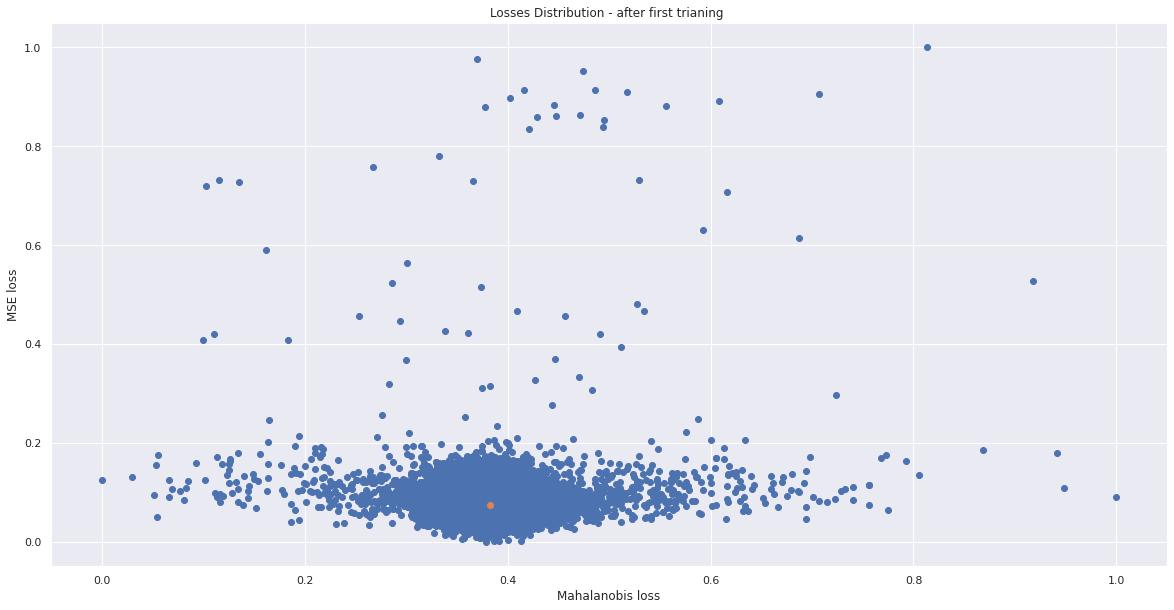

In [16]:
plt.scatter(maha,losses)
plt.scatter(mean_maha,mean_losses)
plt.axis('on')
plt.title("Losses Distribution - after first trianing ")
plt.ylabel('MSE loss')
plt.xlabel('Mahalanobis loss')

Finding anomalous patches

In [17]:
sensitivity_indexes=1140
anomaly_indexes_mahanobolis, losses_with_maha_1 = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, sensitivity_indexes, 0 , maha)
high_sensitivity_indicies_maha = anomaly_indexes_mahanobolis
high_sensitivity_img_maha = get_image_with_patches(high_sensitivity_indicies_maha, patch_shape_error, folder_name, file_name)


In [18]:
low_sensitivity_indexes =30
medium_sensitivity_indexes = 15
high_sensitivity_indexes = 7


In [19]:
high_sensitivity_indexes_mahanobolis, losses_with_maha = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, high_sensitivity_indexes, 0 , maha)
high_sensitivity_img_maha = get_image_with_patches(high_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
high_sensitivity_img_maha = cv2.cvtColor(high_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

medium_sensitivity_indexes_mahanobolis, _ = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, medium_sensitivity_indexes, 0 , maha)
medium_sensitivity_img_maha = get_image_with_patches(medium_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
medium_sensitivity_img_maha = cv2.cvtColor(medium_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

low_sensitivity_indexes_mahanobolis,_ = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, low_sensitivity_indexes, 0 , maha)
low_sensitivity_img_maha = get_image_with_patches(low_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
low_sensitivity_img_maha = cv2.cvtColor(low_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

Presenting the anomalous patches

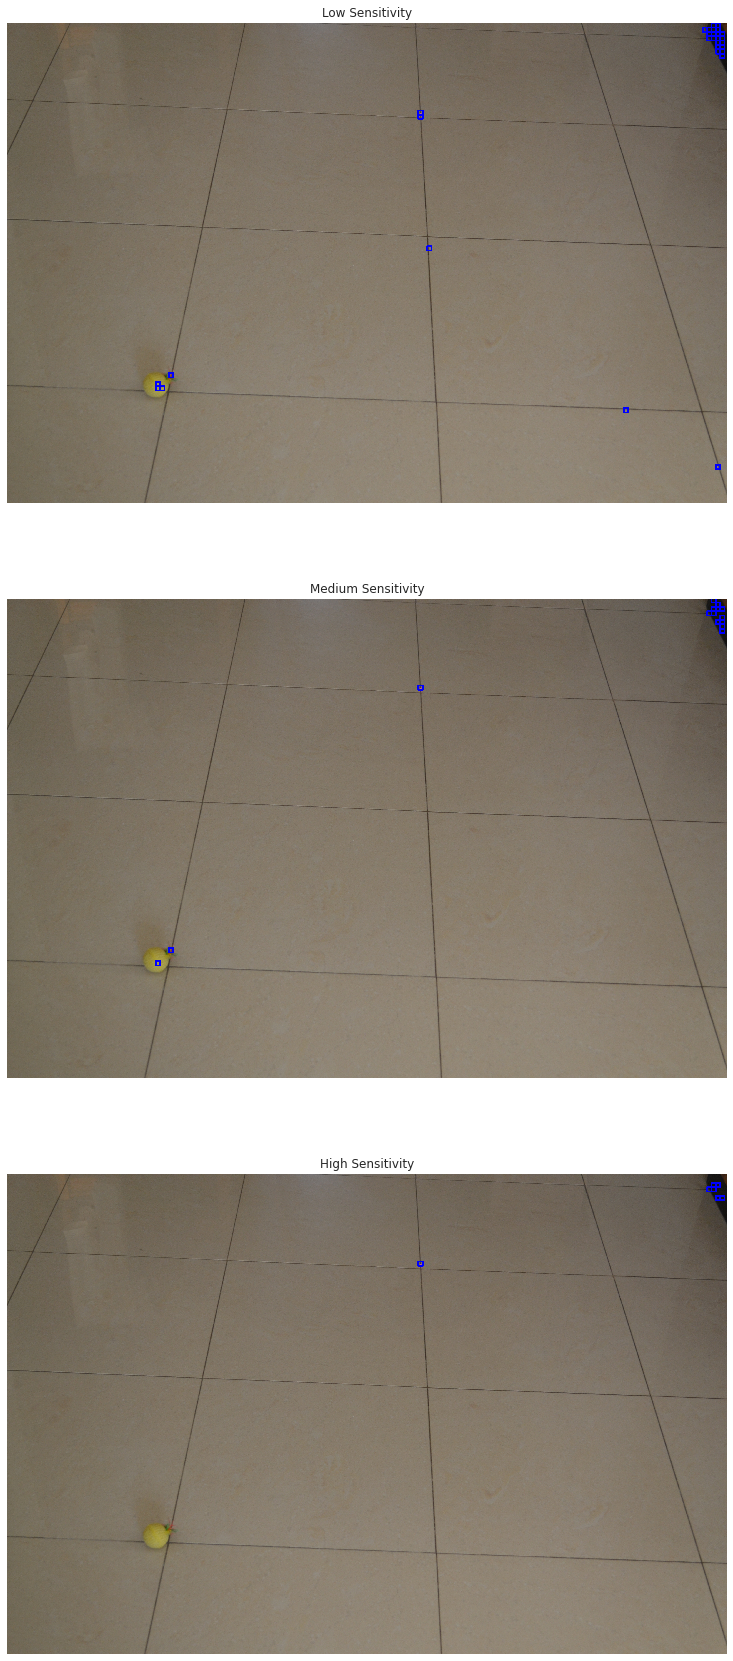

In [20]:
plt.subplots(3,1,figsize=(35,30))
plt.subplot(3,1,1)
plt.axis('off')
plt.title("Low Sensitivity")
plt.imshow(low_sensitivity_img_maha, interpolation='nearest')

plt.subplot(3,1,2)
plt.axis('off')
plt.title("Medium Sensitivity")
plt.imshow(medium_sensitivity_img_maha, interpolation='nearest')

plt.subplot(3,1,3)
plt.axis('off')
plt.title("High Sensitivity")
plt.imshow(high_sensitivity_img_maha, interpolation='nearest')

Presenting heat map

In [21]:
heat_map_maha = np.zeros((hight, width))
for index, _ in enumerate(losses):
  j, i = index % width, index//width
  heat_map_maha[i][j] = losses_with_maha_1[index]

Text(0.5, 1.0, 'total heat map - First training')

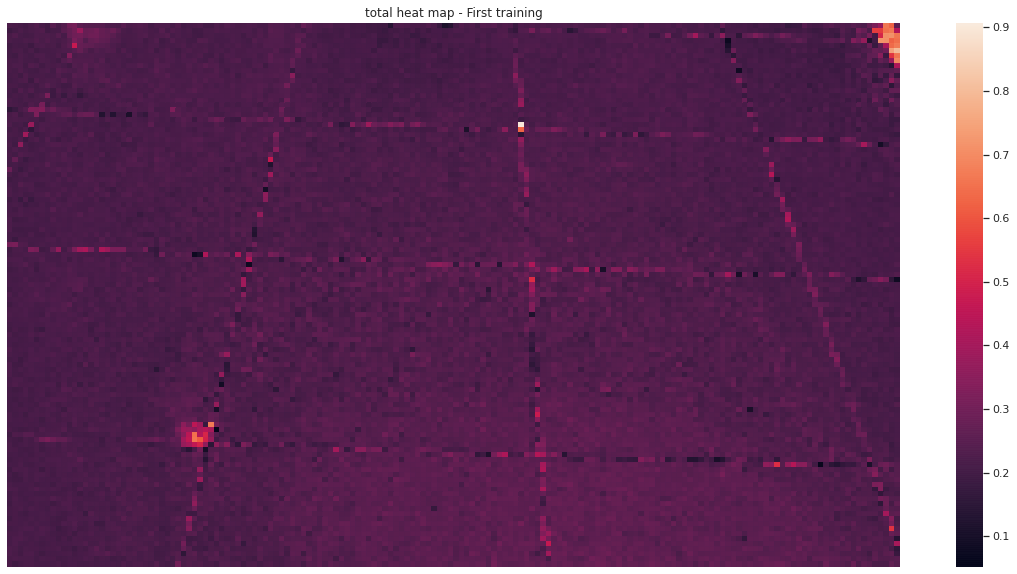

In [22]:
alpha = 0.99 # control the alpha value of the heat-map
h = sns.heatmap(heat_map_maha, alpha=alpha, zorder=2)
h.imshow(original, aspect=h.get_aspect(),
        extent= h.get_xlim() + h.get_ylim(),
        zorder=1)
plt.axis('off')
plt.title("total heat map - First training")

Preparing the anomalous patches for a new training

In [23]:
original_patches_28 = create_patches(grayIm_as_tensor, (1, 28, 28))
repeat_patches = []
new_data = []
for index in anomaly_indexes_mahanobolis:
  repeat_patches.append(original_patches_28[index])
repeat_patches = torch.stack(repeat_patches)
#new_data.append([repeat_patches])
original_patches_28 = torch.vstack(original_patches_28)

In [24]:
combined_repeat_patches = repeat_patches
new_data.append([combined_repeat_patches])


*Training* the model (only anomalous patches)

In [25]:


gf = load_gray_image(folder_name, file_name)
grayfloor_as_tensor = to_normalize(to_tensor(gf))

all_latent_vec = []
all_reconstructed_images = []

for k, data in enumerate(new_data):
  # setup of the model

  for  croped_patch in data :
    # setup data for training
    croped_patch = croped_patch.to(device).type(dtype)

    training_percent = 1
    training_len = int(len(croped_patch)*training_percent)
    test_len = len(croped_patch) - training_len
    
    X_train, X_test = torch.utils.data.random_split(croped_patch, [training_len, test_len])
    
    batch_size = (combined_repeat_patches.size()[0])//10
    train_data_loader = torch.utils.data.DataLoader(dataset=X_train,
                                                    batch_size=batch_size,
                                                    shuffle=True)
    print(k, len(X_train), "epoch:", len(X_train)//batch_size)    
    
    # outputs = []
    amount = 0.02
    num_epochs = len(X_train)//batch_size 
    print(len(X_train))
    # training loop
    _ = training_loop(num_epochs ,train_data_loader, model, criterion, optimizer , final_loss)

  # reconstructing the image
  torch.cuda.empty_cache()

  normalized_image = grayfloor_as_tensor.cuda()
  patches_to_reconstruct = create_patches(normalized_image, (1, *patch_shape_train))
  patches = torch.stack(patches_to_reconstruct)

  latent, recon = model(patches)
  reconstructed_images = recon.detach().cpu().numpy()
  latent_vec = latent.detach().cpu().numpy()


  # clear useless cuda memory 
  if recon is not None: del recon; recon = None 
  if latent is not None: del latent; latent = None
  torch.cuda.empty_cache()

  reconstructed_images = reconstructed_images.reshape(len(reconstructed_images), *reconstructed_images.shape[2:])
  reconstructed_images = combine_patches(reconstructed_images, np.array(grayfloor_as_tensor[0]).shape)

  del patches
  torch.cuda.empty_cache()

  all_latent_vec.append(latent_vec)



  

0 1140 epoch: 10
1140
Epoch:1, Loss:0.0041
Epoch:2, Loss:0.0042
Epoch:3, Loss:0.0019
Epoch:4, Loss:0.0019
Epoch:5, Loss:0.0017
Epoch:6, Loss:0.0014
Epoch:7, Loss:0.0017
Epoch:8, Loss:0.0015
Epoch:9, Loss:0.0014
Epoch:10, Loss:0.0015


Finding the anomalous patches

In [26]:
patch_shape_error = (28, 28) 
img = cv2.imread(folder_name + '/' + file_name) 

grayfloor = load_image(folder_name, file_name)
grayfloor_as_tensor = to_tensor(grayfloor)
grayfloor_as_tensor = grayfloor_as_tensor[0, :, :].unsqueeze(0)
grayfloor_as_tensor = to_normalize(grayfloor_as_tensor)
original = grayfloor_as_tensor[0]

new_shape = [(ss//ps)*ps for ss, ps in zip(img.shape, patch_shape_train)]
subtracted = original-reconstructed_images
subtracted = subtracted[:new_shape[0], :new_shape[1]]
patches = create_patches(subtracted, patch_shape_error)
num_of_patches = len(patches)
mse_scores = [np.power(patch, 2).sum() for patch in patches]

losses = np.array(mse_scores[:])
losses = (losses-losses.min())/(losses.max()-losses.min())
recon_shape   = [(ss//ps)*ps for ss, ps in zip(img.shape, patch_shape_train)]
heatmap_shape = [ss//ps for ss, ps in zip((*recon_shape, 3), (*patch_shape_error, 3))]

h, w, _ = heatmap_shape

heat_map = np.zeros((h, w))
for index, _ in enumerate(losses):
  j, i = index % w, index//w
  heat_map[i][j] = losses[index]


Calcualting mean and variance of the latent vectors:

In [27]:
latent_vec = all_latent_vec[0].reshape(-1, 64*2*2)

In [28]:
mean_latent_all_vecs = np.mean(latent_vec , axis = 1)
var_latent_all_vecs = np.var(latent_vec , axis = 1)
print(mean_latent_all_vecs ,var_latent_all_vecs)

mean_latent_vec = np.mean(latent_vec.flatten() , axis = 0)
var_latent_vec = np.var(latent_vec.flatten(), axis = 0)

[0.11413683 0.11351082 0.11371627 ... 0.04375638 0.05256601 0.06034788] [0.11642786 0.11702448 0.11602274 ... 0.03137622 0.04476481 0.06153227]


In [29]:
var_latent_all_vecs.shape, mean_latent_all_vecs.shape, mean_latent_vec.shape, var_latent_vec.shape

((17876,), (17876,), (), ())

Text(0, 0.5, 'Variance of latent vectors')

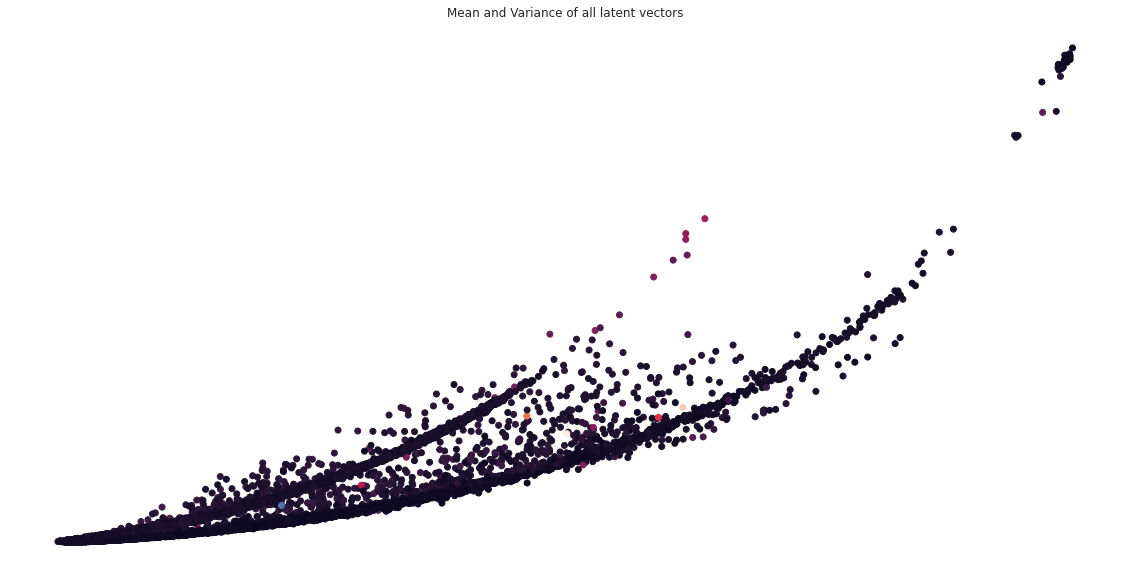

In [30]:
plt.scatter(mean_latent_all_vecs,var_latent_all_vecs, c=losses)
plt.scatter([mean_latent_vec],[var_latent_vec])
plt.axis('off')
plt.title("Mean and Variance of all latent vectors")
plt.xlabel('Mean of latent vectors')
plt.ylabel('Variance of latent vectors')

In [31]:
maha = mahalanobis(latent_vec,latent_vec)
maha = (maha-maha.min())/(maha.max() - maha.min())
mean_maha = maha.mean()
var_maha = maha.var()
mean_losses = np.array(losses).mean()
var_losses = np.array(losses).var()

Presenting error graph

Text(0.5, 0, 'Mahalanobis loss')

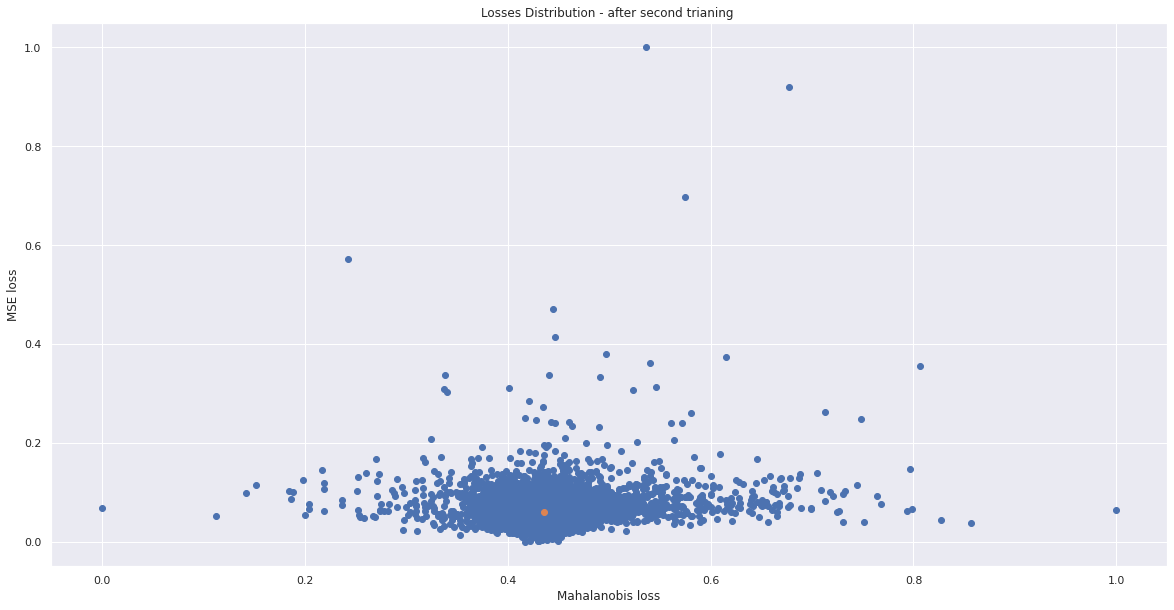

In [32]:
plt.scatter(maha,losses)
plt.scatter(mean_maha,mean_losses)
plt.axis('on')
plt.title("Losses Distribution - after second trianing ")
plt.ylabel('MSE loss')
plt.xlabel('Mahalanobis loss')

In [33]:
low_sensitivity_indexes =30
medium_sensitivity_indexes = 15
high_sensitivity_indexes = 7



Displaying the anomalous patches

In [34]:
high_sensitivity_indexes_mahanobolis, losses_with_maha_2 = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, high_sensitivity_indexes, 0 , maha)
high_sensitivity_img_maha = get_image_with_patches(high_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
high_sensitivity_img_maha = cv2.cvtColor(high_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

medium_sensitivity_indexes_mahanobolis, _ = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, medium_sensitivity_indexes, 0 , maha)
medium_sensitivity_img_maha = get_image_with_patches(medium_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
medium_sensitivity_img_maha = cv2.cvtColor(medium_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

low_sensitivity_indexes_mahanobolis,_ = get_anomalous_patches_indexes_with_mahalanobis(2, heat_map, low_sensitivity_indexes, 0 , maha)
low_sensitivity_img_maha = get_image_with_patches(low_sensitivity_indexes_mahanobolis, patch_shape_error, folder_name, file_name)
low_sensitivity_img_maha = cv2.cvtColor(low_sensitivity_img_maha, cv2.COLOR_BGR2RGB)

In [35]:
heat_map_maha = np.zeros((hight, width))
for index, _ in enumerate(losses):
  j, i = index % width, index//width
  heat_map_maha[i][j] = losses_with_maha_2[index]

Text(0.5, 1.0, 'total heat map - Second training')

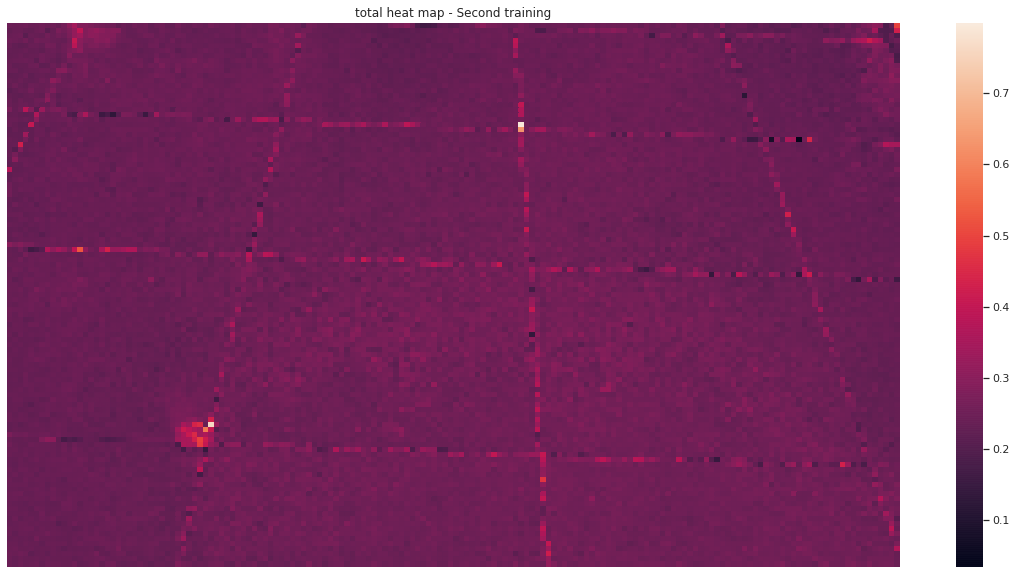

In [36]:
alpha = 0.99 # control the alpha value of the heat-map
h = sns.heatmap(heat_map_maha, alpha=alpha, zorder=2)
h.imshow(original, aspect=h.get_aspect(),
        extent= h.get_xlim() + h.get_ylim(),
        zorder=1)
plt.axis('off')
plt.title("total heat map - Second training")

Displaying the anomalous patches


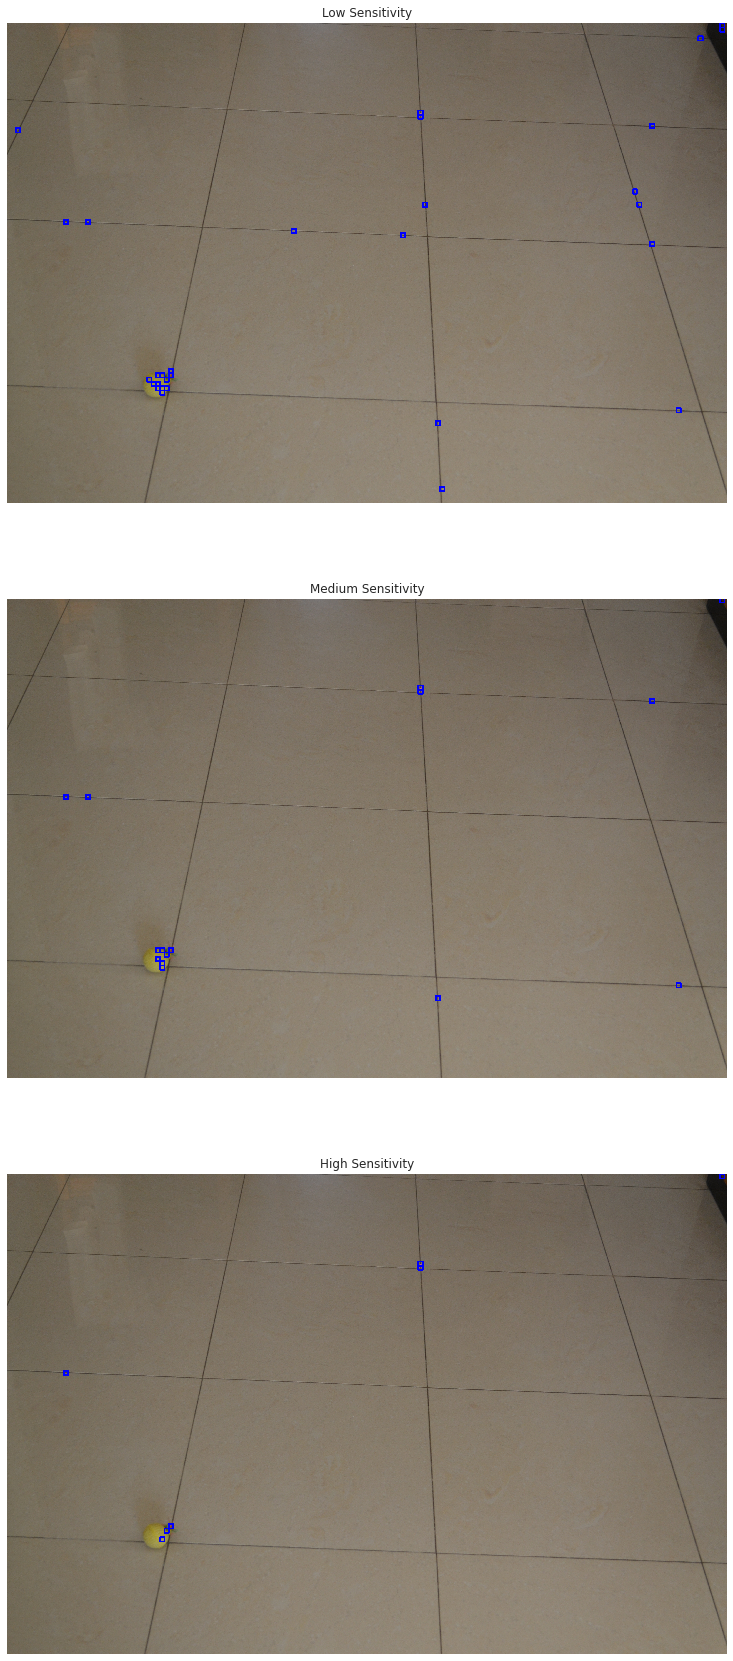

In [37]:
plt.subplots(3,1,figsize=(35,30))
plt.subplot(3,1,1)
plt.axis('off')
plt.title("Low Sensitivity")
plt.imshow(low_sensitivity_img_maha, interpolation='nearest')

plt.subplot(3,1,2)
plt.axis('off')
plt.title("Medium Sensitivity")
plt.imshow(medium_sensitivity_img_maha, interpolation='nearest')

plt.subplot(3,1,3)
plt.axis('off')
plt.title("High Sensitivity")
plt.imshow(high_sensitivity_img_maha, interpolation='nearest')